In [45]:
import os, torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Check CUDA availability
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce GTX 1650 Ti


In [47]:
# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Changed to 28x28 for better compatibility
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Single channel normalization
])

In [48]:
# Create datasets using ImageFolder
train_data = ImageFolder(root='C:\\Users\\arnab\\Documents\\VIT\\SET Project\\OCR\\dataset_split\\train', transform=transform)
val_data = ImageFolder(root='C:\\Users\\arnab\\Documents\\VIT\\SET Project\\OCR\\dataset_split\\val', transform=transform)

In [49]:
# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


In [50]:
# Number of classes
num_classes = len(train_data.classes)
print("Classes:", train_data.classes)
print("Number of classes:", num_classes)

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 34


In [51]:
# Define the CNN model
class CharCNN(nn.Module):
    def __init__(self, num_classes=34):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 28x28 -> 7x7 after 2 pools
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [52]:
# Initialize model, loss, and optimizer
model = CharCNN(num_classes).to(device)
# total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Increased learning rate

Total params: 424,738
Trainable params: 424,738


In [53]:
# --------------------------
# Training function
# --------------------------
def train_epoch(loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return total_loss / len(loader), correct / total

# --------------------------
# Evaluation function (with val_loss)
# --------------------------
def eval_epoch(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total  # return val_loss too

# --------------------------
# Training loop with early stopping
# --------------------------
epochs = 100
best_val_acc = 0
patience = 5
patience_counter = 0

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(epochs):
    # Train
    loss, acc = train_epoch(train_loader)
    
    # Validation
    val_loss, val_acc = eval_epoch(val_loader)

    # Save metrics
    train_loss_history.append(loss)
    train_acc_history.append(acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}: TrainLoss={loss:.4f}, ValLoss={val_loss:.4f}, "
          f"TrainAcc={acc:.3f}, ValAcc={val_acc:.3f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "char_cnn_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Save final model
torch.save(model.state_dict(), "char_cnn_final.pth")
print("✅ Training complete and model saved!")


Epoch 1: TrainLoss=2.2465, ValLoss=1.2490, TrainAcc=0.456, ValAcc=0.714
Epoch 2: TrainLoss=0.9098, ValLoss=0.8041, TrainAcc=0.784, ValAcc=0.798
Epoch 3: TrainLoss=0.6504, ValLoss=0.6699, TrainAcc=0.850, ValAcc=0.847
Epoch 4: TrainLoss=0.5434, ValLoss=0.5706, TrainAcc=0.876, ValAcc=0.877
Epoch 5: TrainLoss=0.4692, ValLoss=0.5240, TrainAcc=0.893, ValAcc=0.883
Epoch 6: TrainLoss=0.4227, ValLoss=0.4686, TrainAcc=0.901, ValAcc=0.896
Epoch 7: TrainLoss=0.3796, ValLoss=0.4444, TrainAcc=0.912, ValAcc=0.904
Epoch 8: TrainLoss=0.3474, ValLoss=0.4104, TrainAcc=0.920, ValAcc=0.914
Epoch 9: TrainLoss=0.3216, ValLoss=0.4043, TrainAcc=0.927, ValAcc=0.914
Epoch 10: TrainLoss=0.2999, ValLoss=0.3758, TrainAcc=0.929, ValAcc=0.919
Epoch 11: TrainLoss=0.2740, ValLoss=0.3629, TrainAcc=0.937, ValAcc=0.920
Epoch 12: TrainLoss=0.2587, ValLoss=0.3422, TrainAcc=0.939, ValAcc=0.929
Epoch 13: TrainLoss=0.2434, ValLoss=0.3386, TrainAcc=0.942, ValAcc=0.927
Epoch 14: TrainLoss=0.2237, ValLoss=0.3411, TrainAcc=0.947, 

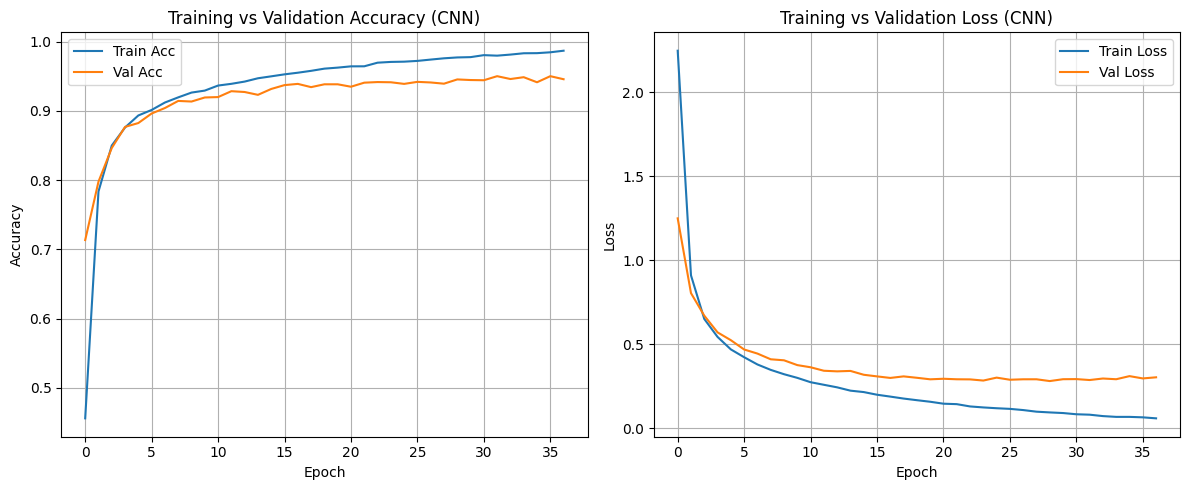

In [55]:


plt.figure(figsize=(12,5))

# --------------------------
# Accuracy Plot
# --------------------------
plt.subplot(1,2,1)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (CNN)")
plt.legend()
plt.grid(True)

# --------------------------
# Loss Plot
# --------------------------
plt.subplot(1,2,2)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (CNN)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
